In [ ]:
%%capture
!pip install transformers
!pip install pytorch-lightning

In [ ]:
import os

import json
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset,DataLoader

from typing import Optional

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import AdamW,T5ForConditionalGeneration,T5TokenizerFast

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pl.seed_everything(42)

Global seed set to 42


42

In [ ]:
%%capture
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [ ]:
file_paths = Path("data/full_dataset").glob("*.csv")

dfs = []
for file_path in file_paths:
     dfs.append(pd.read_csv(file_path))

df = pd.concat(dfs)
df.created_utc = pd.to_datetime(df.created_utc, unit = "s")
df.shape

(211225, 37)

In [ ]:
df.groupby("id").head(1).shape

(58011, 37)

In [ ]:
emotion_categories = df.columns[9:]
emotion_categories

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [ ]:
row = df.iloc[10]
sample_ratings = df[df.id == row.id]
sample_ratings.shape

(5, 37)

In [ ]:
ratings = sample_ratings[emotion_categories]
ratings = ratings.columns[ratings.sum(axis = 0) > 0]
ratings = ", ".join(ratings)
ratings

'approval, confusion, curiosity, neutral'

In [ ]:
print(f"Text :  \n{row.text}")
print(f"Emotions :  {ratings}")

Text :  
How about a downvote for the update?
Emotions :  approval, confusion, curiosity, neutral


In [ ]:
from transformers import ElectraTokenizerFast as ElectraTokenizer

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
encoding = tokenizer(row.text)

print(f"Text : {row.text}")
print(f"Tokens : {encoding.tokens()}")
print(f"Token IDS : {encoding['input_ids']}")

Text : How about a downvote for the update?
Tokens : ['[CLS]', 'how', 'about', 'a', 'down', '##vot', '##e', 'for', 'the', 'update', '?', '[SEP]']
Token IDS : [101, 2129, 2055, 1037, 2091, 22994, 2063, 2005, 1996, 10651, 1029, 102]


In [ ]:
from tqdm import tqdm

token_lens = []
texts = df.groupby("id").head(1).text

for text in tqdm(texts): 
    encoding = tokenizer(text)
    token_lens.append(len(encoding.tokens()))

100%|██████████| 58011/58011 [00:10<00:00, 5347.95it/s]


In [ ]:
pd.Series(token_lens).value_counts().sort_index(ascending = False)[:10]

316    1
115    1
82     1
63     1
57     1
55     1
54     1
53     1
52     2
51     1
dtype: int64

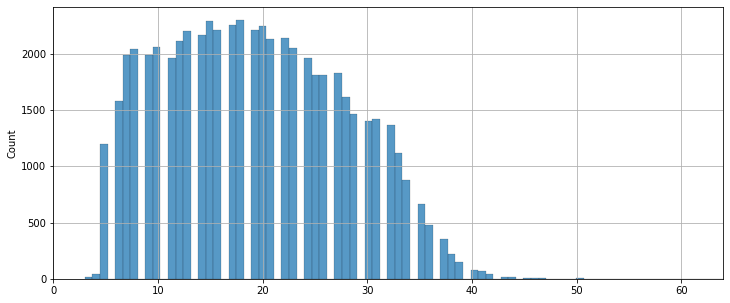

In [ ]:
plt.figure(figsize = (12,5))
sns.histplot(token_lens)
plt.xlim([0,64])
plt.grid()
plt.show()

In [ ]:
texts = []
emotions = []

for comment_id,group in df.groupby("id"):
    texts.append(group.iloc[0].text)
    emotions.append(group[emotion_categories].sum(axis = 0).argmax())

In [ ]:
text_df = pd.DataFrame({"text" : texts, "emotion" : emotions})
text_df.head()

,text,emotion
0,Fast as [NAME] will carry me. Seriously uptown...,4
1,You blew it. They played you like a fiddle.,27
2,TL;DR No more Superbowls for [NAME]. Get ready...,9
3,So much time saved. Not.,7
4,Emotes have a ridiculous amount of effort put ...,27


In [ ]:
class EmotionDataset(torch.utils.data.Dataset):

    def __init__(self,data : pd.DataFrame, tokenizer : ElectraTokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):

        row = self.data.iloc[idx]

        encoding = tokenizer(
            row.text,
            max_length = 64,
            truncation = True,
            padding = "max_length",
            add_special_tokens = True,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors = "pt"
        )

        return {
            "input_ids" : encoding["input_ids"].flatten(),
            "attention_mask" : encoding["attention_mask"].flatten(),
            "label" : torch.tensor(row.emotion)
        }

In [ ]:
ds = EmotionDataset(text_df,tokenizer)
print(len(ds) == len(text_df))

True


In [ ]:
for item in ds:
    print(item["input_ids"][:10])
    print(item["label"])
    break

tensor([ 101, 3435, 2004, 1031, 2171, 1033, 2097, 4287, 2033, 1012])
tensor(4)


In [ ]:
os.cpu_count()

2

In [ ]:
class EmotionDataModule(pl.LightningDataModule):

    def __init__(self,data : pd.DataFrame, tokenizer : ElectraTokenizer, batch_size : int ):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.prepare_data_per_node = True

    def setup(self,stage : Optional[str] = None):

        self.train_df, test_df = train_test_split(self.data, test_size = 0.2)
        self.val_df, self.test_df = train_test_split(test_df, test_size = 0.5)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset = EmotionDataset(self.train_df, self.tokenizer),
            batch_size = self.batch_size,
            num_workers = os.cpu_count(),
            shuffle = True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset = EmotionDataset(self.val_df, self.tokenizer),
            batch_size = self.batch_size,
            num_workers = os.cpu_count(),
            shuffle = False
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset = EmotionDataset(self.test_df, self.tokenizer),
            batch_size = self.batch_size,
            num_workers = os.cpu_count(),
            shuffle = False
        )

In [ ]:
data_module = EmotionDataModule(text_df, tokenizer, batch_size = 32)
data_module.setup()

In [ ]:
for i in data_module.train_dataloader():
    print("Input Ids : " , i["input_ids"].shape)
    print("Attention Mask :", i["attention_mask"].shape)
    print("Label : ", i["label"])
    break

Input Ids :  torch.Size([32, 64])
Attention Mask : torch.Size([32, 64])
Label :  tensor([27, 22, 17, 11, 20, 27,  8, 27, 25,  5, 22, 15, 18,  0,  6,  3,  7, 27,
        27,  4,  4, 27, 25, 27,  7,  3,  5, 10, 27,  5, 27,  3])


----

In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model = "google/electra-base-generator",
    tokenizer = "google/electra-base-generator",
    top_k = 3
)

In [ ]:
text = f"I am not superstitious, but I am a little [MASK]."
print(json.dumps(fill_mask(text), indent=4))

[
    {
        "score": 0.04041881486773491,
        "token": 15743,
        "token_str": "naive",
        "sequence": "i am not superstitious, but i am a little naive."
    },
    {
        "score": 0.031200699508190155,
        "token": 2367,
        "token_str": "different",
        "sequence": "i am not superstitious, but i am a little different."
    },
    {
        "score": 0.025371141731739044,
        "token": 15818,
        "token_str": "arrogant",
        "sequence": "i am not superstitious, but i am a little arrogant."
    }
]


In [ ]:
from transformers import ElectraForPreTraining

model = ElectraForPreTraining.from_pretrained("google/electra-small-discriminator")

In [ ]:
text = f"I am not superstitious, but I am a little yoga."
encoding = tokenizer(text,return_tensors = "pt")
outputs = model(**encoding)

len(encoding.tokens()),encoding.tokens()

(16,
 ['[CLS]',
  'i',
  'am',
  'not',
  'super',
  '##sti',
  '##tious',
  ',',
  'but',
  'i',
  'am',
  'a',
  'little',
  'yoga',
  '.',
  '[SEP]'])

In [ ]:
outputs.keys()

odict_keys(['logits'])

In [ ]:
torch.softmax(outputs.logits,dim = -1),"--",torch.softmax(outputs.logits,dim = -1).sum()

(tensor([[1.8092e-05, 4.5780e-04, 1.1656e-03, 1.2078e-02, 1.7333e-04, 1.8335e-04,
          6.7465e-04, 4.6209e-03, 1.7249e-02, 5.5292e-03, 1.9439e-01, 5.3565e-02,
          1.2615e-01, 5.8141e-01, 2.3138e-03, 1.8052e-05]],
        grad_fn=<SoftmaxBackward0>), '--', tensor(1., grad_fn=<SumBackward0>))

In [ ]:
print(set(tokenizer.special_tokens_map.values()))
print(encoding.tokens())

{'[UNK]', '[MASK]', '[SEP]', '[PAD]', '[CLS]'}
['[CLS]', 'i', 'am', 'not', 'super', '##sti', '##tious', ',', 'but', 'i', 'am', 'a', 'little', 'yoga', '.', '[SEP]']


In [ ]:
def show_detections(tokens,logits):
    replaced_token_index= torch.argmax(logits,dim = -1).item()

    special_tokens = set(tokenizer.special_tokens_map.values())

    for i,token in enumerate(tokens):
        if token in special_tokens:
            continue
        elif i == replaced_token_index:
            print(f"{token} -> replaced")
        else:
            print(f"{token} -> original")

In [ ]:
show_detections(encoding.tokens(),outputs.logits)

i -> original
am -> original
not -> original
super -> original
##sti -> original
##tious -> original
, -> original
but -> original
i -> original
am -> original
a -> original
little -> original
yoga -> replaced
. -> original


---

In [ ]:
from transformers.utils.dummy_pt_objects import ElectraPreTrainedModel

from transformers import ElectraModel,ElectraPreTrainedModel,ElectraTokenizerFast

from transformers.models.electra.modeling_electra import ElectraClassificationHead

In [ ]:
class ElectraClassifier(ElectraPreTrainedModel):

    def __init__(self,config):
        super().__init__(config)

        self.n_classes = config.num_labels
        
        self.config = config
        
        self.electra = ElectraModel(config)
        
        self.classifier = ElectraClassificationHead(config)

        self.post_init()

    def forward(
        self,
        input_ids = None,
        attention_mask = None
    ):

        # Electra Model !!!
        discriminator_hidden_states = self.electra(input_ids,attention_mask)

        sequence_output = discriminator_hidden_states[0]
        

        # ElectraClassification !!!
        logits = self.classifier(sequence_output)
        
        return logits

In [ ]:
class EmotionClassifier(pl.LightningModule):
    def __init__(self, 
                 n_classes, 
                 learning_rate : Optional[float] = None
                 ):
        
        super().__init__()
        self.n_classes = n_classes

        self.classifier = ElectraClassifier.from_pretrained(
            "google/electra-small-discriminator",
            num_labels = n_classes
            )
    
        self.criterion = torch.nn.CrossEntropyLoss()
        self.learning_rate = learning_rate


    def forward(self,input_ids,attention_mask):

        return self.classifier(input_ids,attention_mask)

    def run_step(self,batch, stage):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"].long()
        logits = self(input_ids,attention_mask)
        
        loss = self.criterion(logits,labels)

        self.log(f"{stage}_loss",loss, on_step = True, on_epoch = True, prog_bar = True)

    def training_step(self,batch, batch_idx):
        return self.run_step(batch,"train")

    def validation_step(self,batch, batch_idx):
        return self.run_step(batch,"val")

    def test_step(self,batch, batch_idx):
        return self.run_step(batch,"test")

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr = self.learning_rate)

In [ ]:
MAX_LEARNING_RATE = 1e-2
BATCH_SIZE = 512
TRAINING_STEPS = 650

data_module = EmotionDataModule(
    text_df,
    tokenizer,
    batch_size = BATCH_SIZE 
)
#data_module.setup()

model = EmotionClassifier(
    n_classes = len(emotion_categories),
    learning_rate = MAX_LEARNING_RATE,
)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.de

In [ ]:
trainer = pl.Trainer(
    auto_lr_find=True,
    gpus = 1,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# lr_finder = trainer.tuner.lr_find(model,
#                                  data_module,
#                                  max_lr = MAX_LEARNING_RATE)
#
#
# fig = lr_finder.plot(suggest = True)
# fig.show()
#
# new_lr = lr_finder.suggestion()
#
# model.learning_rate = new_lr


In [ ]:
%load_ext tensorboard

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

experiments_dir = "experiments"

model_checkpoint = ModelCheckpoint(
    filename = "{epoch}-{step}-{val_loss:.2f}",
    save_last = True,
    save_top_k = 3,
    monitor = "val_loss_epoch",
    mode = "min"
)

early_stopping = EarlyStopping(monitor = "val_loss",patience = 2)

logger = TensorBoardLogger(save_dir = experiments_dir,name = "emotion_classification")

In [ ]:
!rm -rf /content/experiments
!rm -rf /content/save_emotion_classifier

In [ ]:
%tensorboard --logdir experiments

In [ ]:
trainer = pl.Trainer(
    default_root_dir = experiments_dir,
    gpus = 1,
    max_steps = TRAINING_STEPS,
    val_check_interval = 40,
    callbacks = [
                 #early_stopping,
                 model_checkpoint],
    logger = logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,data_module)

Missing logger folder: experiments/emotion_classification
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | ElectraClassifier | 13.6 M
1 | criterion  | CrossEntropyLoss  | 0     
-------------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.224    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test(datamodule = data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at experiments/emotion_classification/version_0/checkpoints/epoch=0-step=40-val_loss=3.35.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at experiments/emotion_classification/version_0/checkpoints/epoch=0-step=40-val_loss=3.35.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         3.353574275970459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 3.353574275970459}]

In [ ]:
model.classifier.save_pretrained("save_emotion_classifier")

In [ ]:
%%capture
!apt-get install tree

In [ ]:
!tree save_emotion_classifier

save_emotion_classifier
├── config.json
└── pytorch_model.bin

0 directories, 2 files


In [ ]:
!head save_emotion_classifier/config.json

{
  "_name_or_path": "google/electra-small-discriminator",
  "architectures": [
    "ElectraClassifier"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
